In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as opt
from datasets import load_metric
from torch.utils.data import DataLoader, random_split
from tqdm.notebook import tqdm
import torchinfo

from utils import OCRTokenizer, OCRDataset, collate_batch, save_experiment_info

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

## Tokenizer & Dataset

In [3]:
tokenizer = OCRTokenizer('./synthetic_dataset/train/labels.txt')
tokenizer.counter.most_common(5)

[(' ', 10061), ('8', 3028), ('S', 3012), ('b', 3006), ('V', 2992)]

In [4]:
train_dataset = OCRDataset('./synthetic_dataset/train/', tokenizer, do_train_transform=True, image_size=(256, 256))  # need quadratic images for vit, 64 h for others
val_dataset = OCRDataset('./synthetic_dataset/val/', tokenizer, do_train_transform=False, image_size=(256, 256))
test_dataset = OCRDataset('./synthetic_dataset/test/', tokenizer, do_train_transform=False, image_size=(256, 256))
test_captchas_dataset = OCRDataset('./synthetic_dataset/test_captchas/', tokenizer, do_train_transform=False, image_size=(256, 256))
len(train_dataset), len(val_dataset), len(test_dataset), len(test_captchas_dataset)

(20000, 1500, 5000, 5000)

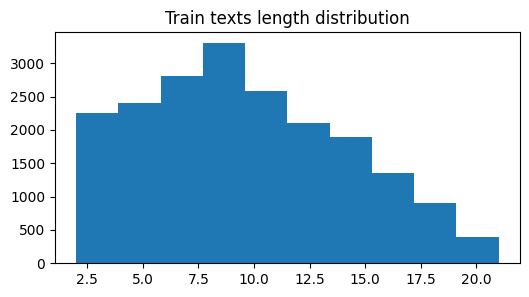

In [5]:
plt.figure(figsize=(6, 3))
plt.hist(np.array(list(map(lambda x: len(x[1]), train_dataset.data))))
plt.title('Train texts length distribution')
plt.show()

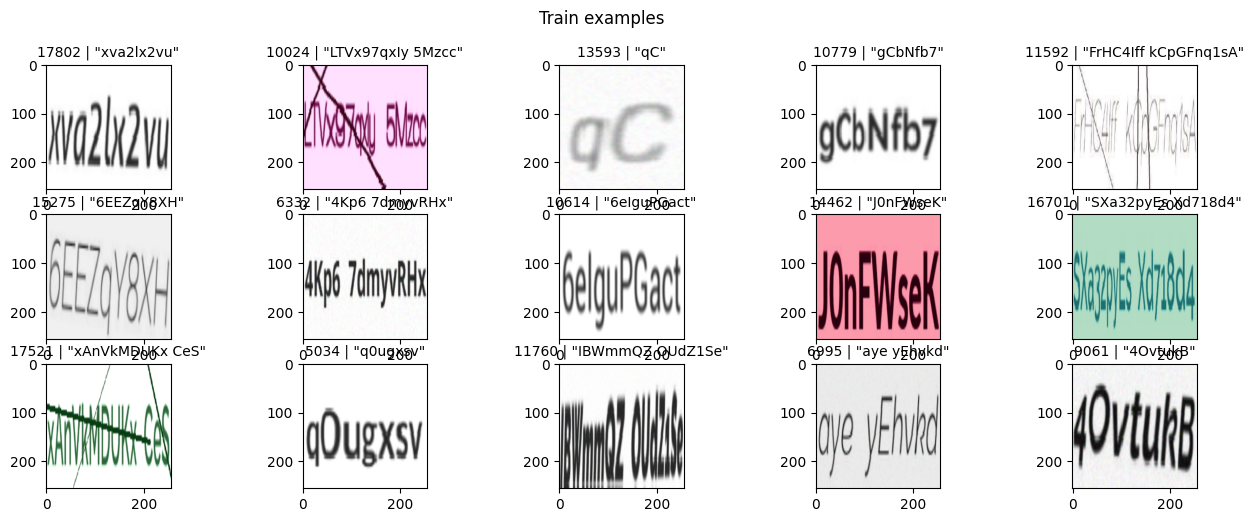

In [6]:
fig, axs = plt.subplots(3, 5, figsize=(16, 5.5))
for i in range(15):
    ax = axs[i // 5][i % 5]
    random_index = np.random.randint(0, len(train_dataset))
    ax.imshow(train_dataset.__getitem__(random_index)['image'].permute(1, 2, 0))
    ax.grid(False)
    text = "".join(tokenizer.decode(train_dataset[random_index]["labels"]))
    ax.set_title(f'{random_index} | "{text}"', fontsize=10)
fig.suptitle('Train examples')
plt.show()

## Modeling

In [7]:
from transformers import ViTConfig
from modeling.encoders.cnn_bilstm import OCR_CRNN, OCR_CARNN, OCR_CRNNA
from modeling.encoders.cnn_transformer import OCR_CNNBERT
from modeling.encoders.vit_bilstm import OCR_ViTRNN

In [8]:
# model = OCR_CNNBERT(vocab_size=len(tokenizer), hidden_dim=128,
#                     nhead=2, dim_feedforward=512, tr_layers=4, dropout=0.1).to(device).eval()
# model

In [9]:
# model = OCR_CRNN(vocab_size=len(tokenizer), hidden_dim=128,
#                  lstm_layers=2, dropout=0.1).to(device).eval()
# model

In [11]:
config = ViTConfig(hidden_size=128, num_hidden_layers=6,
                   intermediate_size=512, patch_size=32, image_size=256, qkv_bias=False,
                   attention_probs_dropout_prob=0.0, hidden_dropout_prob=0.1, num_attention_heads=2)
model = OCR_ViTRNN(vit_config=config, vocab_size=len(tokenizer), lstm_layers=2, dropout=0.1).to(device).eval()
model

OCR_ViTRNN(
  (batch_norm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(32, 32), stride=(32, 32))
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=False)
              (key): Linear(in_features=128, out_features=128, bias=False)
              (value): Linear(in_features=128, out_features=128, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
     

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                                  Param #
OCR_ViTRNN                                              --
├─BatchNorm2d: 1-1                                      6
├─ViTModel: 1-2                                         --
│    └─ViTEmbeddings: 2-1                               8,448
│    │    └─ViTPatchEmbeddings: 3-1                     393,344
│    │    └─Dropout: 3-2                                --
│    └─ViTEncoder: 2-2                                  --
│    │    └─ModuleList: 3-3                             1,187,328
│    └─LayerNorm: 2-3                                   256
├─BiLSTMImageDecoder: 1-3                               --
│    └─BatchNorm1d: 2-4                                 130
│    └─LSTM: 2-5                                        659,456
│    └─Linear: 2-6                                      16,705
├─LogSoftmax: 1-4                                       --
Total params: 2,265,673
Trainable params: 2,265,673
Non-trainable params: 0

In [13]:
model.encoder(torch.rand([2, 3, 256, 256]).to(device)).last_hidden_state.shape

torch.Size([2, 65, 128])

## Training

In [15]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, collate_fn=lambda x: collate_batch(x, tokenizer), num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, collate_fn=lambda x: collate_batch(x, tokenizer), num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, collate_fn=lambda x: collate_batch(x, tokenizer), num_workers=6)
test_captchas_loader = DataLoader(test_captchas_dataset, batch_size=512, shuffle=False, collate_fn=lambda x: collate_batch(x, tokenizer), num_workers=6)

In [16]:
num_epochs = 200
criterion = nn.CTCLoss(zero_infinity=True, blank=tokenizer.pad_token_id)
# criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = opt.AdamW(model.parameters(), lr=5e-4)
wer_metric, cer_metric = load_metric('wer'), load_metric('cer')

/tmp/ipykernel_165935/4162284212.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric, cer_metric = load_metric('wer'), load_metric('cer')


In [17]:
def evaluate(model, data_loader, eval_er_scores = True):
    model.eval()
    losses, wer_scores, cer_scores = [], [], []
    for batch in data_loader:
        with torch.inference_mode():
            inputs, target_labels, target_lengths = batch['inputs'].to(device), batch['labels'].to(device), batch['lengths'].to(device)
            bs = inputs.shape[0]

            predictions = model(inputs)
            pridicted_labels = predictions.permute(1, 0, 2).argmax(-1)

            # CTCLoss
            input_lengths = torch.full(size=(bs,), fill_value=predictions.shape[0], dtype=torch.long)
            loss = criterion(predictions, target_labels, input_lengths, target_lengths)

            # CrossEntropy (needs same seq len in targets and predictions)
            # loss = criterion(predictions.permute(1, 0, 2).contiguous().view(-1, predictions.shape[-1]), target_labels.view(-1))

            # WER & CER
            if eval_er_scores:
                predicted_texts = tokenizer.decode_batch(pridicted_labels, drop_special=True, to_text=True)
                target_texts = tokenizer.decode_batch(target_labels, drop_special=True, to_text=True)
                wer_score = wer_metric.compute(predictions=predicted_texts, references=target_texts)
                cer_score = cer_metric.compute(predictions=predicted_texts, references=target_texts)

        losses.append(loss.detach().item())
        if eval_er_scores:
            wer_scores.append(wer_score)
            cer_scores.append(cer_score)

    if eval_er_scores:
        return np.mean(losses).round(5), np.mean(wer_scores).round(5), np.mean(cer_scores).round(5)
    else:
        return np.mean(losses).round(5), None, None

In [18]:
%%time
evaluate(model, val_loader, eval_er_scores=False)

CPU times: user 415 ms, sys: 527 ms, total: 942 ms
Wall time: 2.21 s


(35.97881, None, None)

In [19]:
%%time
evaluate(model, test_loader, eval_er_scores=False)

CPU times: user 1.09 s, sys: 1.07 s, total: 2.17 s
Wall time: 3.59 s


(36.30176, None, None)

In [20]:
def train(model, checkpoints_dir):
    Path(checkpoints_dir).mkdir(parents=True, exist_ok=True)
    losses_history = {
        'train': [],
        'eval': []
    }
    min_eval_loss = 999999999.9

    for epoch in tqdm(range(num_epochs)):
        model.train()
        print(f'---------- | Epoch: {epoch} | ----------')
        train_losses = []

        for batch in train_loader:
            inputs, target_labels, target_lengths = batch['inputs'].to(device), batch['labels'].to(device), batch['lengths'].to(device)

            predictions = model(inputs)
            input_lengths = torch.full(size=(inputs.shape[0],), fill_value=predictions.shape[0], dtype=torch.long)
            loss = criterion(predictions, target_labels, input_lengths, target_lengths)

            loss.backward()

            train_losses.append(loss.item())

            optimizer.step()
            optimizer.zero_grad()

            # progress_bar.update(1)
        train_loss = np.array(train_losses).mean()
        eval_scores = evaluate(model, val_loader, eval_er_scores=(epoch % 3 == 0 and epoch > 14))

        losses_history['train'].append(train_loss)
        losses_history['eval'].append(eval_scores[0])

        print(f'[TRAIN] Mean epoch loss: {train_loss}')
        print(f'[EVAL] Mean epoch loss: {eval_scores[0]}, WER: {eval_scores[1]}, CER: {eval_scores[2]}')

        if eval_scores[0] < min_eval_loss:
            print(f'Current best on eval, saving model to {checkpoints_dir}...')
            torch.save(model, checkpoints_dir + 'best_model.pth')
            tokenizer.save_to(checkpoints_dir + 'tokenizer.pickle')
            min_eval_loss = eval_scores[0]

        save_experiment_info(model, losses_history, checkpoints_dir + 'experiment_info.json')

    return losses_history

In [24]:
history = train(model, checkpoints_dir='./experiments/vit_128_512_6l_2h_65seq_lstm_2l_400e/')

  0%|          | 0/200 [00:00<?, ?it/s]

---------- | Epoch: 0 | ----------
[TRAIN] Mean epoch loss: 1.1397836027266104
[EVAL] Mean epoch loss: 1.2069, WER: None, CER: None
Current best on eval, saving model to ./experiments/vit_128_512_6l_2h_65seq_lstm_2l_400e/...
---------- | Epoch: 1 | ----------
[TRAIN] Mean epoch loss: 1.135824865932706
[EVAL] Mean epoch loss: 1.17463, WER: None, CER: None
Current best on eval, saving model to ./experiments/vit_128_512_6l_2h_65seq_lstm_2l_400e/...
---------- | Epoch: 2 | ----------
[TRAIN] Mean epoch loss: 1.128569495828846
[EVAL] Mean epoch loss: 1.17738, WER: None, CER: None
---------- | Epoch: 3 | ----------
[TRAIN] Mean epoch loss: 1.125587419618534
[EVAL] Mean epoch loss: 1.17239, WER: None, CER: None
Current best on eval, saving model to ./experiments/vit_128_512_6l_2h_65seq_lstm_2l_400e/...
---------- | Epoch: 4 | ----------
[TRAIN] Mean epoch loss: 1.111249929741968
[EVAL] Mean epoch loss: 1.18439, WER: None, CER: None
---------- | Epoch: 5 | ----------
[TRAIN] Mean epoch loss: 1

[TRAIN] Mean epoch loss: 0.9732922066616106
[EVAL] Mean epoch loss: 1.02128, WER: None, CER: None
Current best on eval, saving model to ./experiments/vit_128_512_6l_2h_65seq_lstm_2l_400e/...
---------- | Epoch: 45 | ----------
[TRAIN] Mean epoch loss: 0.9594361940516701
[EVAL] Mean epoch loss: 1.02225, WER: 0.89321, CER: 0.46457
---------- | Epoch: 46 | ----------
[TRAIN] Mean epoch loss: 0.9523814350743837
[EVAL] Mean epoch loss: 1.02726, WER: None, CER: None
---------- | Epoch: 47 | ----------
[TRAIN] Mean epoch loss: 0.9462103187283383
[EVAL] Mean epoch loss: 1.01061, WER: None, CER: None
Current best on eval, saving model to ./experiments/vit_128_512_6l_2h_65seq_lstm_2l_400e/...
---------- | Epoch: 48 | ----------
[TRAIN] Mean epoch loss: 0.9473920645593088
[EVAL] Mean epoch loss: 1.01514, WER: 0.89748, CER: 0.4682
---------- | Epoch: 49 | ----------
[TRAIN] Mean epoch loss: 0.9479771150818354
[EVAL] Mean epoch loss: 1.00854, WER: None, CER: None
Current best on eval, saving model 

[TRAIN] Mean epoch loss: 0.8078308392174637
[EVAL] Mean epoch loss: 0.88644, WER: 0.87385, CER: 0.43767
Current best on eval, saving model to ./experiments/vit_128_512_6l_2h_65seq_lstm_2l_400e/...
---------- | Epoch: 94 | ----------
[TRAIN] Mean epoch loss: 0.8061544110503378
[EVAL] Mean epoch loss: 0.8852, WER: None, CER: None
Current best on eval, saving model to ./experiments/vit_128_512_6l_2h_65seq_lstm_2l_400e/...
---------- | Epoch: 95 | ----------
[TRAIN] Mean epoch loss: 0.7974804398379748
[EVAL] Mean epoch loss: 0.86917, WER: None, CER: None
Current best on eval, saving model to ./experiments/vit_128_512_6l_2h_65seq_lstm_2l_400e/...
---------- | Epoch: 96 | ----------
[TRAIN] Mean epoch loss: 0.7981118431574181
[EVAL] Mean epoch loss: 0.87291, WER: 0.89151, CER: 0.44382
---------- | Epoch: 97 | ----------
[TRAIN] Mean epoch loss: 0.7958171918422361
[EVAL] Mean epoch loss: 0.87804, WER: None, CER: None
---------- | Epoch: 98 | ----------
[TRAIN] Mean epoch loss: 0.7936092532133

[TRAIN] Mean epoch loss: 0.6964213780209988
[EVAL] Mean epoch loss: 0.78452, WER: 0.87586, CER: 0.43302
---------- | Epoch: 142 | ----------
[TRAIN] Mean epoch loss: 0.6974076839941966
[EVAL] Mean epoch loss: 0.76341, WER: None, CER: None
Current best on eval, saving model to ./experiments/vit_128_512_6l_2h_65seq_lstm_2l_400e/...
---------- | Epoch: 143 | ----------
[TRAIN] Mean epoch loss: 0.6921646866617324
[EVAL] Mean epoch loss: 0.7888, WER: None, CER: None
---------- | Epoch: 144 | ----------
[TRAIN] Mean epoch loss: 0.6899355234979074
[EVAL] Mean epoch loss: 0.76281, WER: 0.8788, CER: 0.4331
Current best on eval, saving model to ./experiments/vit_128_512_6l_2h_65seq_lstm_2l_400e/...
---------- | Epoch: 145 | ----------
[TRAIN] Mean epoch loss: 0.6770515758779985
[EVAL] Mean epoch loss: 0.7755, WER: None, CER: None
---------- | Epoch: 146 | ----------
[TRAIN] Mean epoch loss: 0.6858053426199322
[EVAL] Mean epoch loss: 0.76231, WER: None, CER: None
Current best on eval, saving mode

[TRAIN] Mean epoch loss: 0.6319500849216799
[EVAL] Mean epoch loss: 0.71401, WER: 0.8804, CER: 0.42688
Current best on eval, saving model to ./experiments/vit_128_512_6l_2h_65seq_lstm_2l_400e/...
---------- | Epoch: 193 | ----------
[TRAIN] Mean epoch loss: 0.6266551779795296
[EVAL] Mean epoch loss: 0.71837, WER: None, CER: None
---------- | Epoch: 194 | ----------
[TRAIN] Mean epoch loss: 0.6364323444004301
[EVAL] Mean epoch loss: 0.70719, WER: None, CER: None
Current best on eval, saving model to ./experiments/vit_128_512_6l_2h_65seq_lstm_2l_400e/...
---------- | Epoch: 195 | ----------
[TRAIN] Mean epoch loss: 0.6309240558479405
[EVAL] Mean epoch loss: 0.71072, WER: 0.87978, CER: 0.42271
---------- | Epoch: 196 | ----------
[TRAIN] Mean epoch loss: 0.622457391853574
[EVAL] Mean epoch loss: 0.72708, WER: None, CER: None
---------- | Epoch: 197 | ----------
[TRAIN] Mean epoch loss: 0.6238415618486042
[EVAL] Mean epoch loss: 0.70024, WER: None, CER: None
Current best on eval, saving mo

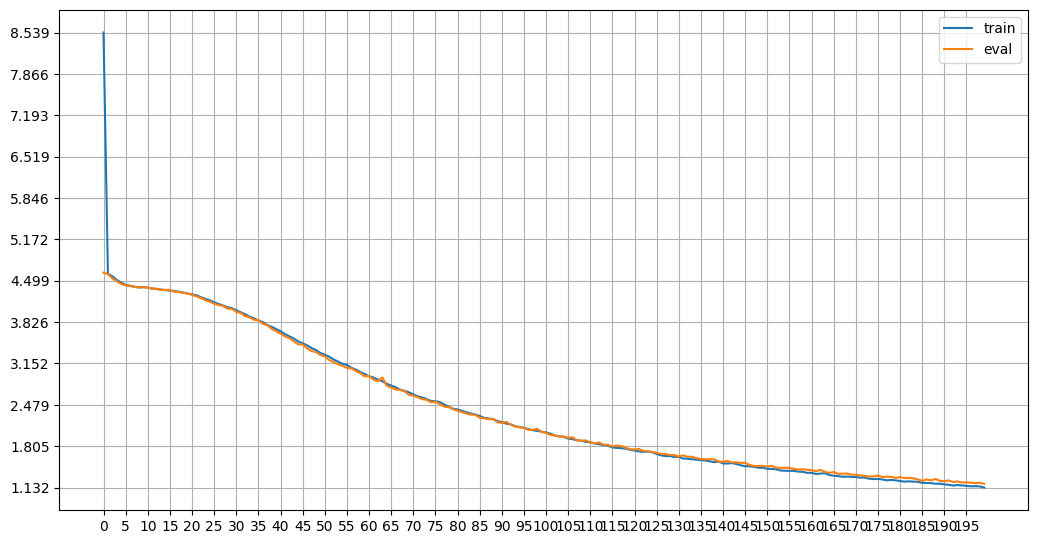

In [22]:
fig = plt.gcf()
fig.set_size_inches(12.5, 6.5)
plt.plot(history['train'], label = 'train')
plt.plot(history['eval'], label = 'eval')
plt.yticks(np.linspace(min(history['train']), max(history['train']), 12))
plt.xticks(range(0, len(history['train']), 5))
plt.grid()
plt.legend()
plt.show()

In [23]:
evaluate(model, test_loader), evaluate(model, test_captchas_loader)

((0.93186, 0.88384, 0.4522), (1.17299, 0.90336, 0.49401))

## Manual testing

In [23]:
best_model = torch.load('./experiments/cnn_v2_128_64seq_lstm_2l_80e_2/best_model.pth').eval()

In [42]:
!ls -lh experiments/

total 16K
drwxrwxr-x 2 hivaze hivaze 4.0K Apr  5 03:05 cnn_v2_128_64seq_alstm_2h_2l_100e
drwxrwxr-x 2 hivaze hivaze 4.0K Apr  5 01:09 cnn_v2_128_64seq_alstm_2h_2l_80e
drwxrwxr-x 2 hivaze hivaze 4.0K Apr  5 03:57 cnn_v2_128_64seq_lstm_2l_100e
drwxrwxr-x 2 hivaze hivaze 4.0K Apr  4 23:57 cnn_v2_128_64seq_lstm_2l_80e


In [24]:
evaluate(best_model, test_loader)

(0.06764, 0.19687, 0.04471)

In [43]:
evaluate(best_model, test_captchas_loader)

(0.1209, 0.25071, 0.05986)

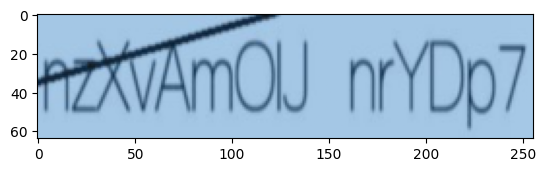

In [73]:
test_image = test_captchas_dataset[np.random.randint(0, len(test_captchas_dataset))]['image']
plt.imshow(test_image.permute(1, 2, 0))

In [74]:
tokenizer.decode(best_model(test_image.unsqueeze(0).to(device)).permute(1, 0, 2).argmax(-1), drop_special=True)

['n',
 'z',
 'X',
 'v',
 'A',
 'm',
 'O',
 'l',
 'J',
 ' ',
 ' ',
 ' ',
 'n',
 'r',
 'Y',
 'D',
 'p',
 '7']